# Libraries

In [44]:
import h5py
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics  import r2_score
from glob             import glob

import matplotlib.pyplot as plt
import scipy.signal      as signal
import torch.nn          as nn
import numpy  			 as np
import pandas 		     as pd


# ECG Definitions

ECG metadata

In [45]:
samplingFrequency = 400

ECG file headers

In [46]:
ecgHeaders = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ECG plot definitions

In [47]:
ecgPlotHeaders = [
	"LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI":   "seagreen",
	"aVR":  "black",
	"V1":   "gold",
	"V4":   "orangered",
	"LII":  "cornflowerblue",
	"aVL":  "seagreen",
	"V2":   "gold",
	"V5":   "crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

# The Dataset: CODE-15

Metadata

In [48]:
dataFolder = "../../../data/CODE15/hdf5/"

In [49]:
ecgFeatures = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgFeaturesIndexes = [ecgHeaders.index(derivation) for derivation in ecgFeatures]
ecgFeaturesIndexes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [50]:
ecgTarget = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgTargetIndexes = [ecgHeaders.index(derivation) for derivation in ecgTarget]
ecgTargetIndexes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Dataset class

In [51]:
class Code15Dataset(Dataset):
	def __init__(self, hdf5Files, features, target, transform):
		
		super().__init__()
		
		self.hdf5Files = hdf5Files
		self.indexMap  = []
		self.features  = features
		self.target    = target
		self.transform = transform


		for fileIndex, path in enumerate(self.hdf5Files):
			
			with h5py.File(path, "r") as f:
				samplesCount = f['exam_id'].shape[0]
				
				self.indexMap.extend([(fileIndex, i) for i in range(samplesCount)])

	def __len__(self):
		return len(self.indexMap)

	def __getitem__(self, idx):

		fileIndex, examIdx = self.indexMap[idx]
		hdf5File           = self.hdf5Files[fileIndex]

		with h5py.File(hdf5File, "r") as file:
			tracing = np.array(file['tracings'][examIdx])

		tracing = self.transform(tracing)

		X = tracing[:, self.features]
		X = torch.tensor(X, dtype = torch.float32)

		Y = tracing[:, self.target]
		Y = torch.tensor(Y, dtype = torch.float32)

		return X, Y


Transform Function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $ N = 600  $ samples
- Gain of 5
- Normalization with z-score

In [52]:
def transform(ecg):
	b, a = signal.butter(
		N     = 1, 
		Wn    = 1, 
		btype = 'high', 
		fs    = samplingFrequency
	)
	
	ecgFiltred  = signal.filtfilt(b, a, ecg, axis = 0)
	ecgWithGain = 5 * ecgFiltred
	ecgClean    = ecgWithGain[600: -600, :]

	ecgMean = np.mean(ecgClean, axis = 0, keepdims = True)
	ecgStd  = np.std(ecgClean,  axis = 0, keepdims = True) + 1e-8

	ecgNormalized = (ecgClean - ecgMean) / ecgStd

	return ecgNormalized


Holdout dataset

In [53]:
dataset = Code15Dataset(
	hdf5Files = glob(f"{dataFolder}/*.hdf5"),
	features  = ecgFeaturesIndexes,
	target    = ecgTargetIndexes,	
	transform = transform
)

In [54]:
len(dataset)

20001

In [55]:
generator = torch.Generator().manual_seed(14)

In [56]:
trainRatio = 0.80

trainSize = int(trainRatio * len(dataset))
testSize  = len(dataset) - trainSize

print("Train dataset Len =", trainSize)
print("Train dataset Len =", testSize)

Train dataset Len = 16000
Train dataset Len = 4001


In [57]:
trainDataset, testDataset = random_split(
	dataset = dataset,
	lengths = [trainSize, testSize]
)

Dataloaders

In [58]:
trainDataloader = DataLoader(
	dataset     = trainDataset,
	batch_size  = 32,
	shuffle     = True,
	num_workers = 4

)

testDataloader = DataLoader(
	dataset     = testDataset,
	batch_size  = 32,
	shuffle     = False,
	num_workers = 4

)

# Model definition

In [59]:
class ECGReconstructor(nn.Module):
    def __init__(self, latentDim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(12, 16, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(32, latentDim, 5, padding = 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(latentDim, 32, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(32, 16, 5, padding = 2),
            nn.ReLU(),
            nn.Conv1d(16, 12, 5, padding = 2)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  

        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)
        decoded = decoded.permute(0, 2, 1)

        return decoded

# Training

Metadata

In [64]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = ECGReconstructor(latentDim = 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()
epochs    = 20

print(device)

cuda


Run

In [65]:
trainingLoss = []

In [66]:
model.train()

for epoch in range(epochs):
	totalLoss = 0

	for X, Y in trainDataloader:
		X, Y = X.to(device), Y.to(device)

		prediction = model(X)
		loss       = criterion(prediction, Y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		totalLoss += loss.item()

	trainingLoss.append(totalLoss / len(trainDataloader))

	print(f"Epoch {epoch + 1}: loss = {trainingLoss[-1]:.4f}")

Epoch 1: loss = 0.1102
Epoch 2: loss = 0.0324
Epoch 3: loss = 0.0201
Epoch 4: loss = 0.0148
Epoch 5: loss = 0.0123
Epoch 6: loss = 0.0110
Epoch 7: loss = 0.0104
Epoch 8: loss = 0.0097
Epoch 9: loss = 0.0093
Epoch 10: loss = 0.0090
Epoch 11: loss = 0.0086
Epoch 12: loss = 0.0083
Epoch 13: loss = 0.0083
Epoch 14: loss = 0.0080
Epoch 15: loss = 0.0080
Epoch 16: loss = 0.0076
Epoch 17: loss = 0.0076
Epoch 18: loss = 0.0074
Epoch 19: loss = 0.0073
Epoch 20: loss = 0.0072


Loss along the epochs

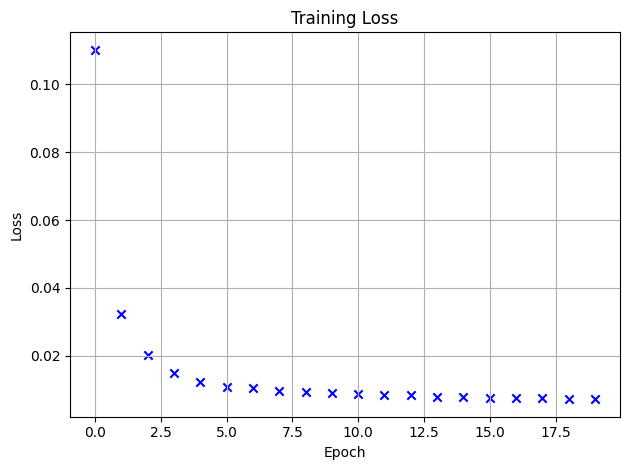

In [67]:
plt.scatter(range(epochs), trainingLoss, c = "blue", marker = "x")

plt.title("Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid()
plt.tight_layout()
plt.show()

# Test

In [68]:
model.eval()

testLoss = 0
testR2   = 0

totalSamples = 0

with torch.no_grad():
	for X, Y in testDataloader:
		X, Y       =  X.to(device), Y.to(device)
		prediction =  model(X)
		loss       =  criterion(prediction, Y)
		testLoss   += loss.item()

		YFlat 		   = Y.cpu().numpy().reshape(-1, Y.shape[-1])
		predictionFlat = prediction.cpu().numpy().reshape(-1, prediction.shape[-1])

		testR2 += r2_score(YFlat, predictionFlat) * YFlat.shape[0]

		totalSamples += YFlat.shape[0]

testR2 /= totalSamples

print(f"Test Loss: {testLoss:.4f}")
print(f"Test R^2:  {testR2:.4f}")


Test Loss: 0.9051
Test R^2:  0.9928


# Ploting

Ploting functions

In [69]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [70]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparison: ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		r2   = np.round(r2_score(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75
		)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha = 0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} r2 = {r2}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

Extract a sample ECG from dataset

In [80]:
sampleECGTensor, _ = trainDataset[2000]

sampleECG = pd.DataFrame(
	columns = ecgFeatures,
	data    = sampleECGTensor
)

sampleECG.head()


,LI,LII,LIII,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-0.692971,-0.327915,0.104465,0.605150,-0.336885,-0.087820,-1.164670,0.502979,-0.634992,-0.109094,0.033543,0.097526
1,-0.157198,-0.189563,-0.076585,0.205957,-0.025040,-0.145406,-1.249005,0.511868,-0.577749,-0.122017,-0.035484,0.127336
2,0.309461,-0.070733,-0.235738,-0.104262,0.303716,-0.193308,-1.092141,0.703248,-0.495139,-0.095476,-0.034829,0.158585
3,0.407955,-0.106679,-0.322464,-0.090549,0.423851,-0.242089,-0.849586,0.806875,-0.463971,-0.065254,-0.056004,0.069404
4,0.304850,-0.153979,-0.305625,-0.006603,0.331014,-0.233031,-0.577665,0.799181,-0.463386,-0.046690,-0.081080,0.020802


In [81]:
with torch.no_grad():
    sampleECGReconstructed = model(sampleECGTensor.unsqueeze(0).to(device)).cpu().numpy()
    sampleECGReconstructed = sampleECGReconstructed.squeeze(0)

sampleECGReconstructed = pd.DataFrame(
    columns = ecgTarget,
    data    = sampleECGReconstructed
)

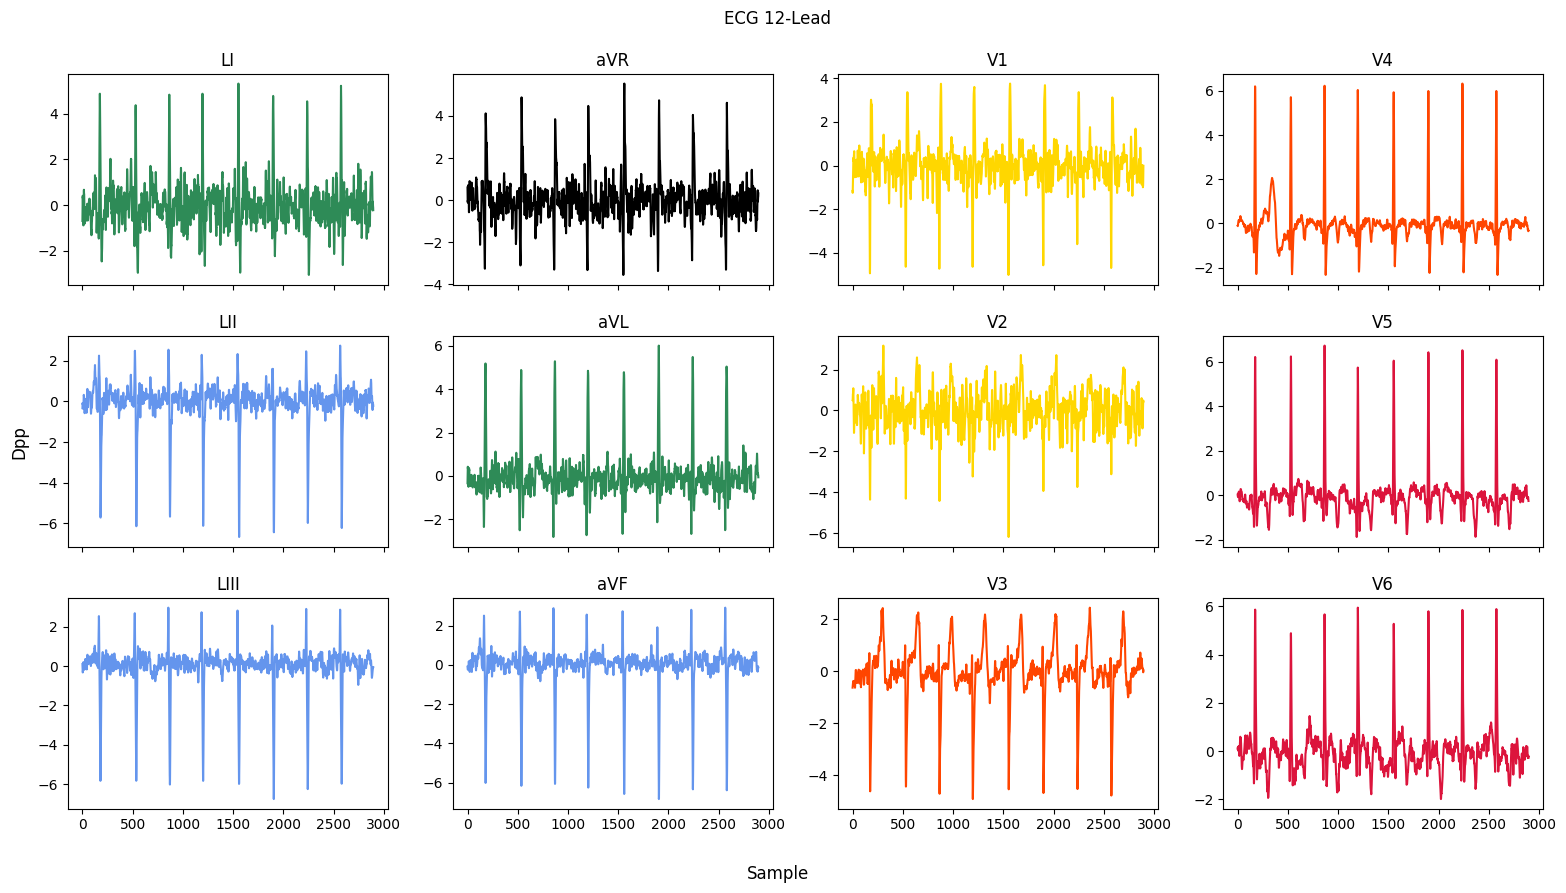

In [82]:
plotECG(
	ecg     = sampleECG,
	headers = ecgPlotHeaders,
	colors  = ecgPlotColors
)

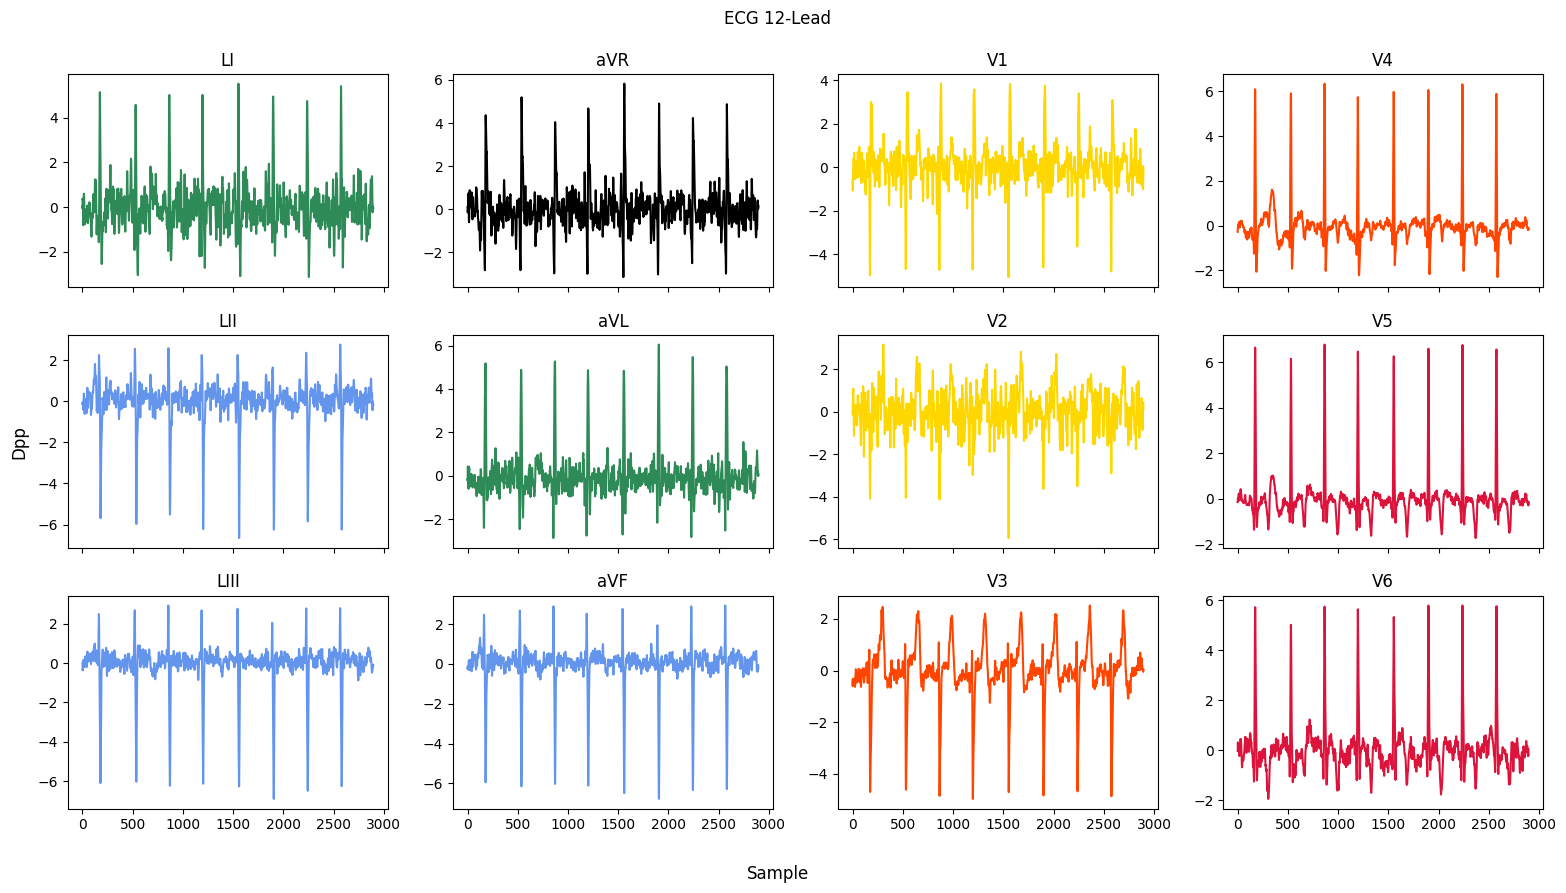

In [83]:
plotECG(
	ecg     = sampleECGReconstructed,
	headers = ecgPlotHeaders,
	colors  = ecgPlotColors
)

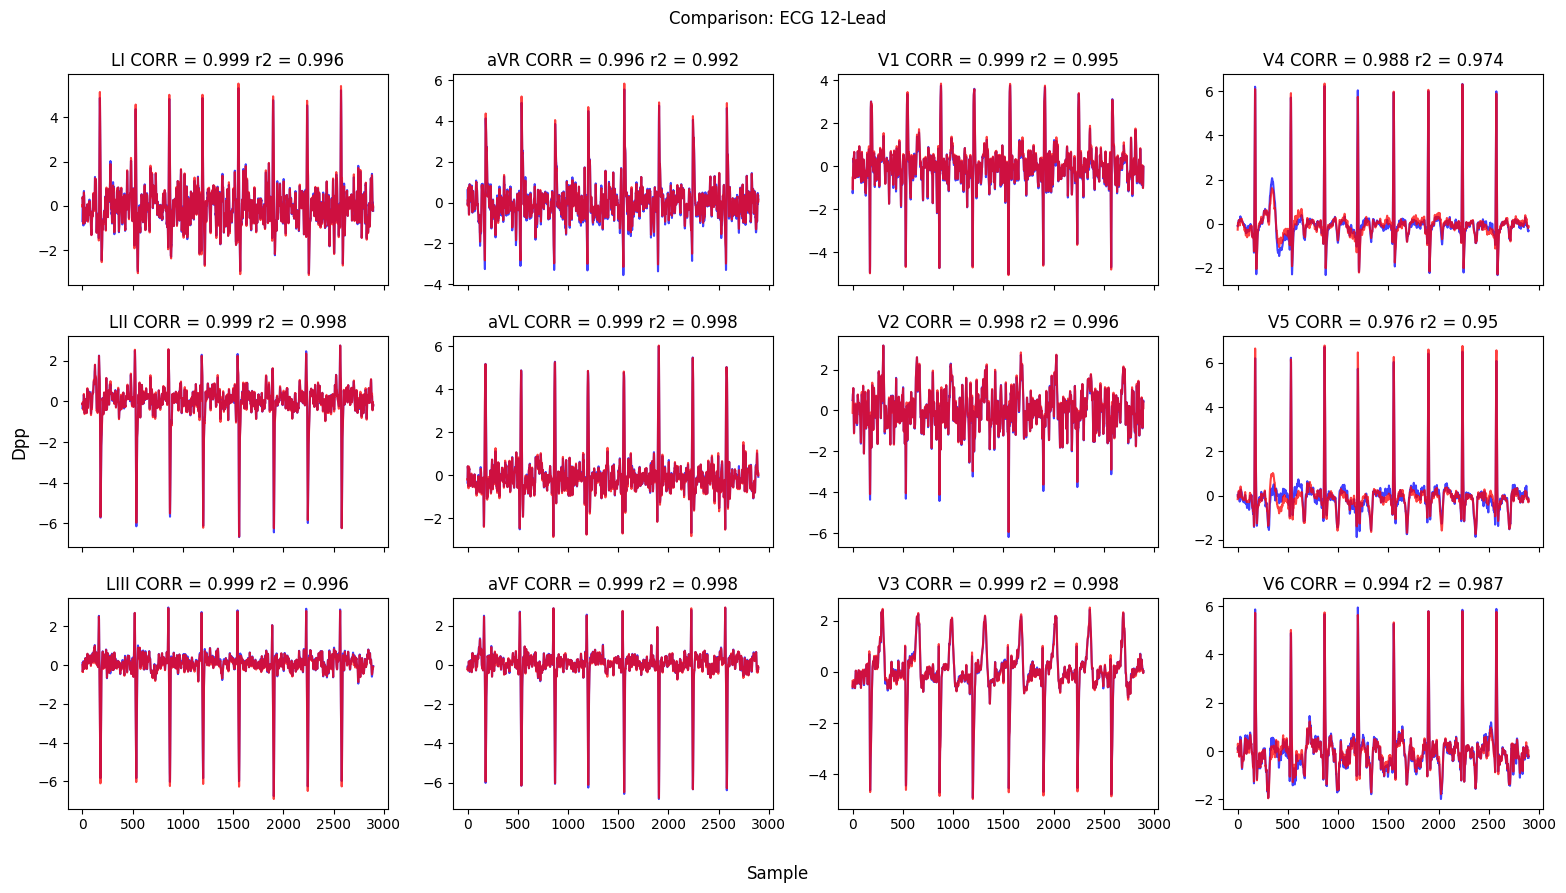

In [84]:
comparativeFullEcgPlot(
	ecgOring = sampleECG,
	ecgRec   = sampleECGReconstructed,
	headers  = ecgPlotHeaders
)

In [85]:
viewWindow = slice(1000, 2000)

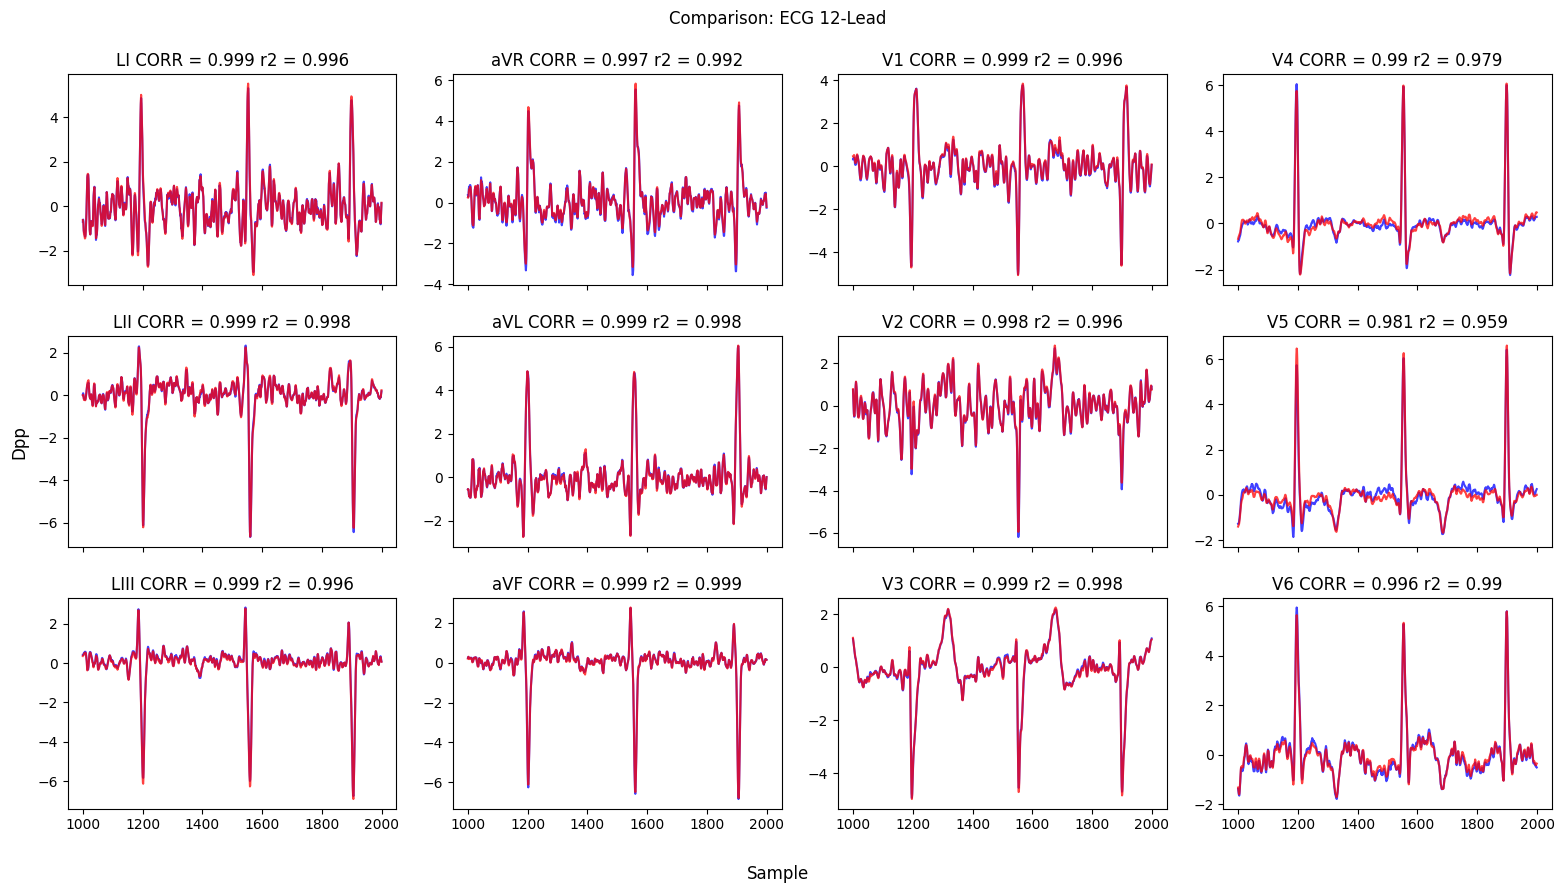

In [86]:
comparativeFullEcgPlot(
	ecgOring = sampleECG[viewWindow],
	ecgRec   = sampleECGReconstructed[viewWindow],
	headers  = ecgPlotHeaders
)

# Save model

In [87]:
torch.save(model.state_dict(), "../../../models/t3/ae-t3-v0.pth")